<div
style= "background-color: #f2f2f2;
        border: 2px solid #f2f2f2;
        color: #000000;
        border-radius: 5px;
        padding: 10px;
        direction: rtl;
        font-family: David;">

# Final Project

## Alaa Sweed -- 318462959

</div>



<div dir="rtl">

# פרוייקט סופי -למידה עמוקה

## בפרוייקט זה אדגים את כל מה שלמדנו בקורס "למידה עמוקה" ונבנה CNN מלא:
</div>


<div
style= "background-color: #f2f2f2;
        border: 2px solid #f2f2f2;
        color: #000000;
        border-radius: 5px;
        padding: 10px;
        direction: rtl;
        font-family: David;">

# Phase 0
## import libs
</div>

In [76]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
import os
import cv2 #Image manipulatin
from matplotlib import pyplot as plt

# Phase 1
Mount to Google Drive and discover the dataset

In [77]:
# prompt: Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Phase 1
## Define data loader to load dataset from train and val

### include Feature Scaling

In [78]:
def load_dataset(batch_size, data_dir):
    """
    This function loads and prepares datasets for training and validation. It returns the data loaders
    for both the training and validation datasets.

    Parameters:
    batch_size (int): The number of samples in each batch of data.
    data_dir (str): The directory where the datasets are located.

    Returns:
    train_loader (DataLoader): DataLoader for the training dataset.
    val_loader (DataLoader): DataLoader for the validation dataset.
    """

    # Define the transforms for the images
    # These transformations include resizing, center cropping, converting images to tensors,
    # and normalizing them based on pre-defined mean and standard deviation values.
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the images to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels from the resized image
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the image with mean values
                             std=[0.229, 0.224, 0.225])   # Normalize the image with standard deviation values
    ])

    # Load the datasets
    # The datasets are assumed to be organized in directories, with one subdirectory per class.
    # The 'train' dataset is loaded from the "train" subdirectory within 'data_dir'
    # The 'val' dataset is loaded from the "val" subdirectory within 'data_dir'
    train_dataset = ImageFolder(os.path.join(data_dir, "train"), transform=transform)
    val_dataset = ImageFolder(os.path.join(data_dir, "val"), transform=transform)

    # Create the data loaders
    # DataLoader is used to iterate through the dataset and fetch batches of data.
    # train_loader fetches batches of data from the training dataset and shuffles the data
    # to ensure random distribution.
    # val_loader fetches batches of data from the validation dataset but does not shuffle the data.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [79]:
def get_classes(data_dir):
    """
    This function lists the classes (subdirectories) inside the 'train' directory of the dataset.

    Parameters:
    data_dir (str): The directory where the datasets are located.

    Returns:
    classes (list): A list of class names (subdirectory names) in the 'train' directory.
    """

    # List the subdirectories in the 'train' directory
    classes = os.listdir(os.path.join(data_dir, "train"))
    return classes

# Example usage:
data_dir = '/content/drive/MyDrive/Colab Notebooks/covid_test/dataset'  # Replace with your actual data directory
classes = get_classes(data_dir)
print(classes)


['no', 'yes']


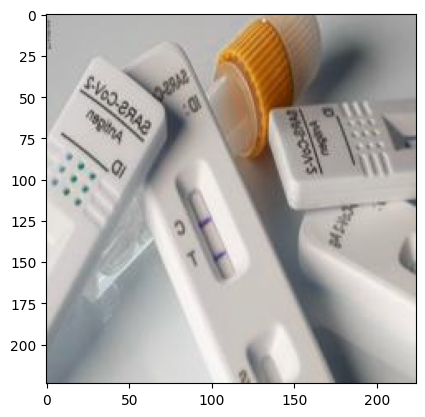

In [80]:
#test for 1 picture

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/covid_test/dataset/train/yes/MGN_COVID-19-antigen-tests_horizonatl.jpg')
plt.imshow(img)
plt.show()

# Phase 2
Model initialization:
1. import ResNet50 which is pre-trained. Namely, the weights are not random

In [81]:
def initialize_model():
    """
    This function initializes a pre-trained ResNet50 model, freezes its parameters,
    and modifies the final fully connected layer to match the number of classes in the dataset.

    Returns:
    model (torchvision.models.ResNet): The modified ResNet50 model ready for training or inference.
    """

    # Load the pre-trained ResNet50 model
    # The ResNet50 model is loaded with pre-trained weights. This model is commonly used for image classification tasks.
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Freeze the model parameters
    # Freezing the parameters ensures that the gradients are not computed for these parameters during backpropagation.
    # This is useful when you want to fine-tune only the final layers of the network.
    for param in model.parameters():
        param.requires_grad = False

    # Modify the final layer to accept the number of classes in the dataset
    # The final fully connected layer (fc) is replaced with a new layer that has 'num_classes' output features.
    # This is necessary because the number of output features of the final layer must match the number of classes in the dataset.
    num_classes = 2  # You can change this to the actual number of classes in your dataset
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


# Phase 3

## implement Traning Function


In [82]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    """
    This function trains a ResNet50 model using the provided training and validation datasets.

    Parameters:
    model (torchvision.models.ResNet): The ResNet50 model to be trained.
    train_loader (DataLoader): DataLoader for the training dataset.
    val_loader (DataLoader): DataLoader for the validation dataset.
    num_epochs (int): The number of epochs for training.
    learning_rate (float): The learning rate for the optimizer.

    Returns:
    model (torchvision.models.ResNet): The trained ResNet50 model.
    """

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)  # Using Adam optimizer for the final layer

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Train the model
    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the model parameters

            # Print progress every 100 batches
            if i % 100 == 99:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
            running_loss += loss.item()

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for data in val_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {100 * correct / total:.2f}%")

    print("Finished Training")
    return model


## Phase 4

## Main Function:

### 1. Load the Dataset
### 2. Initiolize the Model
### 3. Train the Model

In [83]:
# Define the data directory
dataset = "/content/drive/MyDrive/Colab Notebooks/covid_test/dataset"
#call load_dataset(batch_size,data_dir)



In [84]:
# Define the batch size for training and validation
batch_size = 32

# Load the dataset using the load_dataset function
# The function 'load_dataset' is defined earlier and is used to load and prepare the training and validation datasets.
# 'batch_size' specifies the number of samples per batch to load.
# 'dataset' is a variable that should contain the path to the dataset directory.
train_loader, val_loader = load_dataset(batch_size, dataset)


In [85]:
# prompt: initialize the model
# Initialize the model using the initialize_model function
# The function 'initialize_model' is defined earlier and is used to initialize a pre-trained ResNet50 model.
# It modifies the final layer of the model to match the number of classes in the dataset.
model = initialize_model()

# Train

In [86]:
# Define the number of epochs for training
num_epochs = 10

# Define the learning rate for the optimizer
learning_rate = 0.001

# Train the model using the train_model function
# The function 'train_model' is defined earlier and is used to train the ResNet50 model.
# It takes the model, training data loader, validation data loader, number of epochs, and learning rate as inputs.
trained_model = train_model(model, train_loader, val_loader, num_epochs, learning_rate)


Epoch 1/10, Train Loss: 0.6846, Val Loss: 0.6333, Val Accuracy: 62.30%
Epoch 2/10, Train Loss: 0.6347, Val Loss: 0.6170, Val Accuracy: 70.49%
Epoch 3/10, Train Loss: 0.5723, Val Loss: 0.6350, Val Accuracy: 52.46%
Epoch 4/10, Train Loss: 0.5252, Val Loss: 0.5944, Val Accuracy: 62.30%
Epoch 5/10, Train Loss: 0.4894, Val Loss: 0.5660, Val Accuracy: 72.13%
Epoch 6/10, Train Loss: 0.4624, Val Loss: 0.5594, Val Accuracy: 68.85%
Epoch 7/10, Train Loss: 0.4578, Val Loss: 0.5569, Val Accuracy: 63.93%
Epoch 8/10, Train Loss: 0.4241, Val Loss: 0.5363, Val Accuracy: 72.13%
Epoch 9/10, Train Loss: 0.4335, Val Loss: 0.5170, Val Accuracy: 83.61%
Epoch 10/10, Train Loss: 0.3913, Val Loss: 0.5421, Val Accuracy: 70.49%
Finished Training


In [87]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def inference_single_image(model, image_path):
    """
    This function performs inference on a single image using a trained model.

    Parameters:
    model (torchvision.models.ResNet): The trained ResNet50 model.
    image_path (str): The path to the image file.

    Returns:
    predicted_label (str): The predicted class label for the image.
    """

    # Load the image
    image = Image.open(image_path).convert("RGB")  # Ensure image has 3 channels

    # Define the transforms
    transform = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels from the resized image
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the image with mean values
                             std=[0.229, 0.224, 0.225])  # Normalize the image with standard deviation values
    ])

    # Transform the image
    image = transform(image)

    # Add a batch dimension
    image = image.unsqueeze(0)

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        output = model(image)

    # Get the predicted class
    _, predicted = torch.max(output.data, 1)
    predicted_class = predicted.item()

    # Map the predicted class index to the corresponding class label
    class_names = ['NEG', 'POS']  # Replace with your actual class names
    predicted_label = class_names[predicted_class]

    return predicted_label

# Perform inference on the single image
image_path = '/content/drive/MyDrive/Colab Notebooks/covid_test/Inference/NEG3.jpg'
predicted_label = inference_single_image(trained_model, image_path)

print(f"Predicted class for {image_path}: {predicted_label}")


Predicted class for /content/drive/MyDrive/Colab Notebooks/covid_test/Inference/NEG3.jpg: NEG


In [88]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import os

# Phase 5
# Inference

# Define the transforms for the inference images
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),  # Crop the center 224x224 pixels from the resized image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize the image with mean values
                         std=[0.229, 0.224, 0.225])  # Normalize the image with standard deviation values
])

# Load the inference images
infer_dir = "/content/drive/MyDrive/Colab Notebooks/covid_test/Inference"  # Directory containing inference images
image_files = [f for f in os.listdir(infer_dir) if os.path.isfile(os.path.join(infer_dir, f))]  # List all image files

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = trained_model.to(device)  # Move the trained model to the selected device

# Class names mapping
class_names = ['NEG', 'POS']  # Make sure these class names match your training data

# Perform inference
trained_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(infer_dir, image_file)  # Get the full path of the image
        image = Image.open(image_path).convert("RGB")  # Open the image and ensure it has 3 channels
        input_tensor = transform(image).unsqueeze(0).to(device)  # Transform the image and add a batch dimension

        outputs = trained_model(input_tensor)  # Perform inference
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class index

        # Map the predicted class to the class name
        predicted_class_name = class_names[predicted.item()]

        print(f"Image {i+1} ({image_file}): Predicted class: {predicted_class_name}")  # Print the result


Image 1 (NEG1.jpg): Predicted class: POS
Image 2 (NEG2.jpg): Predicted class: POS
Image 3 (NEG3.jpg): Predicted class: NEG
Image 4 (POS6.jpg): Predicted class: POS
Image 5 (POS4.jpg): Predicted class: POS
Image 6 (POS5.jpg): Predicted class: POS
Image 7 (POS7.jpg): Predicted class: POS
Image 8 (NEG4.jpg): Predicted class: POS
Image 9 (NEG5.jpg): Predicted class: POS
Image 10 (POS8.jpg): Predicted class: POS
Image 11 (NEG6.jpg): Predicted class: POS
Image 12 (NEG7.jpg): Predicted class: NEG
Image 13 (NEG8.jpg): Predicted class: POS
Image 14 (NEG9.jpg): Predicted class: POS
Image 15 (NEG10.jpg): Predicted class: POS
Image 16 (POS9.jpg): Predicted class: POS
Image 17 (POS10.jpg): Predicted class: POS
Image 18 (POS3.jpg): Predicted class: NEG
Image 19 (POS2.jpg): Predicted class: POS
Image 20 (POS1.jpg): Predicted class: POS


In [89]:
# prompt: help me understand of 0 is pos or negative and same for 1

# Class names mapping
class_names = ['NEG', 'POS']  # Make sure these class names match your training data

# Print the mapping
print("Class Mapping:")
for i, class_name in enumerate(class_names):
    print(f"{i} -> {class_name}")


Class Mapping:
0 -> NEG
1 -> POS
